# Time Series Forecasting with NimbusML

This tutorial is an introduction to time series forecasting.

This class implements the general anomaly detection transform based on [Singular Spectrum Analysis (SSA)](https://en.wikipedia.org/wiki/Singular_spectrum_analysis). SSA is a powerful framework for decomposing the time-series into trend, seasonality and noise components as well as forecasting the future values of the time-series. In principle, SSA performs spectral analysis on the input time-series where each component in the spectrum corresponds to a trend, seasonal or noise component in the time-series. For details of the Singular Spectrum Analysis (SSA), refer to this [document](https://arxiv.org/pdf/1206.6910.pdf).

In [61]:
# --------------------------------------------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.
# --------------------------------------------------------------------------------------------

In [1]:
import os
import pandas as pdThis tutorial is an introduction to time series forecasting.

This class implements the general anomaly detection transform based on [Singular Spectrum Analysis (SSA)](https://en.wikipedia.org/wiki/Singular_spectrum_analysis). SSA is a powerful framework for decomposing the time-series into trend, seasonality and noise components as well as forecasting the future values of the time-series. In principle, SSA performs spectral analysis on the input time-series where each component in the spectrum corresponds to a trend, seasonal or noise component in the time-series. For details of the Singular Spectrum Analysis (SSA), refer to this [document](https://arxiv.org/pdf/1206.6910.pdf).
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from nimbusml import Pipeline
from nimbusml.timeseries import SsaForecaster
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The Weather Dataset

This tutorial uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/index.php/Main/HomePage).

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, we will use only the data collected between 2009 and 2016 to predict future air temperature. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

In [2]:
# Load image summary data from github
url_to_csv = "https://raw.githubusercontent.com/mstfbl/NimbusML-Samples/masterEe/datasets/max_planck_weather_time_series_dataset.csv"
df_train = pd.read_csv(filepath_or_buffer=url_to_csv, sep = ",",)

Let's look at our data.

In [4]:
df_train.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Here, we can see that a recording is made every 10 minutes. So for a single hour, there are 6 recordings. This means there are 144 (6 * 24) recordings per week, 1008 (144 * 7) recordings per week, around 30,240 (144 * 7 * 30) recordings per month, and around 362,880 (30,240 * 12) recordings per year.

To predict one or more time-steps into the future, we will make use of the recordings. For example, to predict 6 hours into the future, we will utilize the immediate previous recordings in our dataset.

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(staLet's look at our data.rt_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [6]:
TRAIN_SPLIT = 300000

## Single-step prediction

For the first part of this tutorial, we will train our SSA Forecaster model on past air temperature data to predict one time-step into the future. We first start by extracting temperature data from our dataset.

In [7]:
data_univariate = df_train['T (degC)']
data_univariate.index = df_train['Date Time']
data_univariate.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's look at the entire temperature dataset we have. Notice the cycles that occur around every year, and how these cycles repeat across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028D1AEA00B8>],
      dtype=object)

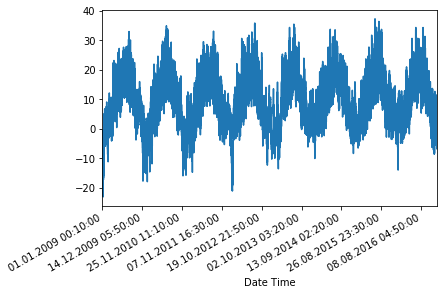

In [8]:
data_univariate.plot(subplots=True)

Let's look at the entire temperature dataset we have. Notice the cycles that occur around every year, and how these cycles repeat across time.

In [9]:
data_univariate = data_univariate.values
data_univariate_mean = data_univariate[:TRAIN_SPLIT].mean()
data_univariate_std = data_univariate[:TRAIN_SPLIT].std()
data_univariate = (data_univariate-data_univariate_mean)/data_univariate_std

In [10]:
univariate_past_history = 21
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(data_univariate, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(data_univariate, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [11]:
print(len(x_val_uni))

120530


In [12]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]
 [-2.10418486]]

 Target temperature to predict
-2.0949220845536356


In [13]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [14]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\mubal\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

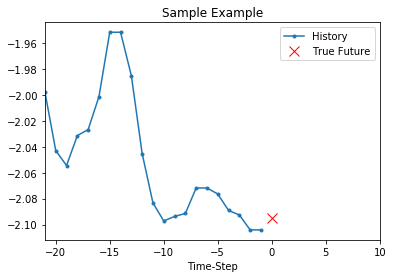

In [15]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [16]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\mubal\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

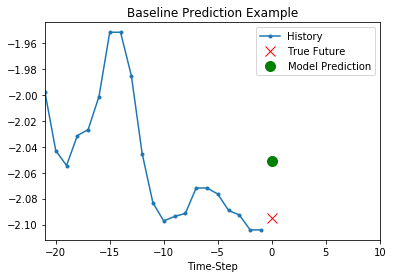

In [17]:
#print(x_train_uni[0])
#print(y_train_uni[0])
#print(baseline(x_train_uni[0]))
#print(x_train_uni.shape[-2:])
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

In [18]:
x_val_uni_list = [x[0] for x in x_val_uni[0].tolist()]
X_val_ssa = pd.Series(x_val_uni_list, name="T (degC)")
#print(X_val_ssa)
#print(len(x_train_uni[0])) #almost 2100 days worth of data
x_train_uni_list_big = x_train_uni.flatten()
X_train_ssa_big = pd.Series(x_train_uni_list_big, name="T (degC)")
#print(X_train_ssa_big.head())

In [19]:
#seasonality_size = 52560 # 365 (length of season in days) * 144 (with 10 minute interval samples, 144 samples in one day)
#training_seasons = 749950 #roughly 8 seasons displayed in entire dataset, so len(X_train_ssa_big) / 8
#training_size = seasonality_size * training_seasons
#pipeline = Pipeline([
#    SsaForecaster(series_length= 449996, #arbitrary for now
#                  train_size= training_size,
#                  window_size= seasonality_size + 1,
#                  horizon=3,
#                  columns={'T (degC)_fc': 'T (degC)'})
#])

In [20]:
# Parameters to be tuned later
pipeline = Pipeline([
    SsaForecaster(series_length=6,
                  train_size=20,
                  window_size=3,
                  horizon=1,
                  columns={'T (degC)_fc': 'T (degC)'})
])

In [21]:
print(len(X_train_ssa_big))
pipeline.fit(X_train_ssa_big)
print(X_train_ssa_big)

6299559
Elapsed time: 00:00:00.6647938
0         -1.997663
1         -2.042819
2         -2.054397
3         -2.031241
4         -2.026609
             ...   
6299554    0.652649
6299555    0.652649
6299556    0.648017
6299557    0.644544
6299558    0.644544
Name: T (degC), Length: 6299559, dtype: float64


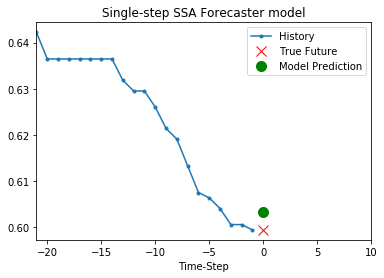

In [22]:
predicted_val_uni = pipeline.transform(X_val_ssa)
predicted_val = predicted_val_uni['T (degC)_fc.0'][20]
plot = show_plot([x_val_uni[0], y_val_uni[0], predicted_val], 0, 'Single-step SSA Forecaster model')
plot.show()

In [23]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

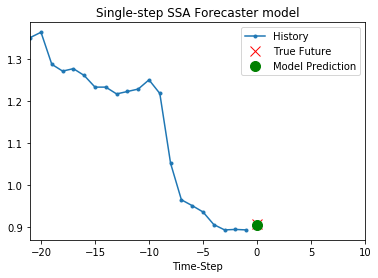

Absolute Percentage Error: 0.19276763070832698%%


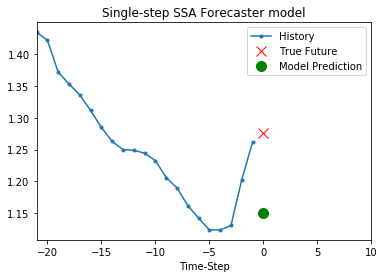

Absolute Percentage Error: 9.839462362162594%%


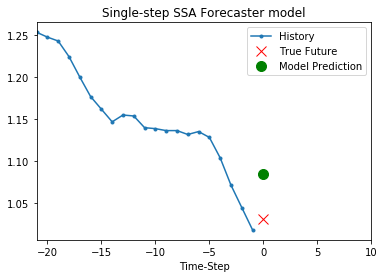

Absolute Percentage Error: 5.258218012180816%%


In [24]:
random_is = np.random.randint(len(x_val_uni), size=3)
for i in random_is:
    # Predicting
    x_val_uni_list = [x[0] for x in x_val_uni[i].tolist()]
    X_val_ssa = pd.Series(x_val_uni_list, name="T (degC)")
    predicted_val_uni = pipeline.transform(X_val_ssa)
    predicted_val = predicted_val_uni['T (degC)_fc.0'][19]
    plot = show_plot([x_val_uni[i], y_val_uni[i], predicted_val], 0, 'Single-step SSA Forecaster model')
    plot.show()
    # Performace
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    abe = abs(((y_val_uni[i] - predicted_val) / y_val_uni[i]) * 100)
    print("Absolute Percentage Error: {}%%".format(abe))

In [25]:
#Performance testing for 1000 random single-step SSA Forecasts
num_predictions = 1000
random_is = np.random.randint(len(x_val_uni), size=num_predictions)
mapes = [-1 for _ in range(num_predictions)]
for c, i in enumerate(random_is):
    # Predicting
    x_val_uni_list = [x[0] for x in x_val_uni[i].tolist()]
    X_val_ssa = pd.Series(x_val_uni_list, name="T (degC)")
    predicted_val_uni = pipeline.transform(X_val_ssa)
    predicted_val = predicted_val_uni['T (degC)_fc.0'][19]
    # Performace
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    mapes[c] = abs(y_val_uni[i] - predicted_val) / abs(y_val_uni[i]) * 100
print("Mean absolute percentage error of {} samples for single-Step SSA forecasting: {}%.".format(len(mapes), np.mean(mapes)))

ERROR - Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-a387449dab1a>", line 9, in <module>
    predicted_val_uni = pipeline.transform(X_val_ssa)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\internal\utils\utils.py", line 220, in wrapper
    params = func(*args, **kwargs)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\pipeline.py", line 2283, in transform
    **params)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\internal\utils\entrypoints.py", line 438, in run
    output_modelfilename)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\internal\utils\entrypoints.py", line 274, in _try_call_bridge
    ret = px_call(call_parameters)
KeyboardInterrupt

During handling of the above ex

KeyboardInterrupt: 

In [ ]:
#Validating on the entire validation dataset of size 119759 data points, 
print("Size of training dataset for SSA Single-Step Forecasting on NimbusML: {}.".format(len(x_train_uni)))
print("Size of validation dataset for SSA Single-Step Forecasting on NimbusML: {}.".format(len(x_val_uni)))
mapes_total = 0
iter_count = 0
for i in range(len(x_val_uni)):
    # Predicting
    x_val_uni_list = [x[0] for x in x_val_uni[i].tolist()]
    X_val_ssa = pd.Series(x_val_uni_list, name="T (degC)")
    predicted_val_uni = pipeline.transform(X_val_ssa)
    predicted_val = predicted_val_uni['T (degC)_fc.0'][19]
    # Performace
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    mapesTotal += abs(y_val_uni[i] - predicted_val) / abs(y_val_uni[i])
    if iter_count % 1000 == 0:
        print("Iteration {}/{} - Current MAPE: {}%".format(iter_count, len(x_val_uni), mapes_total*100/iter_count))
    iter_count += 1
print("Mean absolute percentage error of {} samples for single-Step SSA forecasting: {}%.".format(len(mapes), mapes_total*100/iter_count))

**Multi-step prediction**

In [26]:
features_considered = ['T (degC)']

In [27]:
features = df_train[features_considered]
features.index = df_train['Date Time']
features.head()

,T (degC)
Date Time,
01.01.2009 00:10:00,-8.02
01.01.2009 00:20:00,-8.41
01.01.2009 00:30:00,-8.51
01.01.2009 00:40:00,-8.31
01.01.2009 00:50:00,-8.27


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028D2A7EA160>],
      dtype=object)

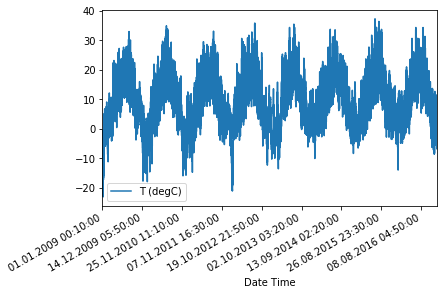

In [28]:
features.plot(subplots=True)

In [29]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [30]:
dataset = (dataset-data_mean)/data_std

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 720
future_target = 72
STEP = 6
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [32]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [33]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [34]:
random_is = np.random.randint(len(x_val_uni), size=3)
for i in random_is:
    multi_step_plot(x_train_multi[i], y_train_multi[i], np.array([0]))

NameError: name 'x_train_multi' is not defined

### Validating Multi-Step SSA Forecasting with Progressive Training
The size of x_train_multi is 299280 data points, which corresponds to around 2078 days of weather data.
The size of x_val_multi is 119759 data points, which corresponds to around 831 days of weather data.

With a Time Series model, it's important to regularly update the state of the model with new observed data points to ensure the accuracy as new predictions are performed. For this reason, a Time Series model is stateful.

In [35]:
def multivariate_data_progressive(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [36]:
past_history = 720
future_target = 72
STEP = 6
x_multi_progressive, y_multi_progressive = multivariate_data_progressive(dataset, dataset[:, 0], 0,
                                                 None, past_history,
                                                 future_target, STEP)

In [59]:
print("Size of input data per transform: {}".format(len(x_multi_progressive)))
print("Size of output label data per transform: {}".format(len(y_multi_progressive)))

Size of input data per transform: 419759
Size of output label data per transform: 419759


In [37]:
def get_multi_prog_ssa_pipeline(given_series_length, seasonality_size, training_seasons, horizon):
    training_size = seasonality_size * training_seasons
    return Pipeline([
        SsaForecaster(series_length= given_series_length,
                      train_size= training_size,
                      window_size= seasonality_size + 1,
                      horizon=72,
                      columns={'T (degC)_fc': 'T (degC)'})
])

In [64]:
#With Gani's progressive SSA Training idea
#Validating on the entire validation dataset of size 119759 data points, 
print("Size of training dataset for SSA Multi-Step Forecasting (Progressive Training) on NimbusML: {}.".format(len(x_multi_progressive)))
mape_raw_total = 0
iter_count = 0
#limit = 100
#for i in range(1000):
for i in range(len(y_multi_progressive)-2):
    # Predicting
    #     x_multi_progressive[:i].flatten() is equivalent to batch[i]
    B_val_multi_prog_ssa = pd.Series(x_multi_progressive[:i+1].flatten(), name="T (degC)")
    pipeline_multi_prog_ssa_pipeline = get_multi_prog_ssa_pipeline(90*(i+1), 24, 4*(i+1), 72)
    pipeline_multi_prog_ssa_pipeline.fit(B_val_multi_prog_ssa, verbose=0)
    # Predicted values
    p_val_multi_prog_ssa = pipeline_multi_prog_ssa_pipeline.transform(pd.Series(x_multi_progressive[i].flatten(), name="T (degC)")).drop("T (degC)", 1)
    #print(p_val_multi_prog_ssa)
    predicted_vals_multi = [0 for _ in range(72)]
    count = 0
    for (_, columnData) in p_val_multi_prog_ssa.iteritems():
        predicted_vals_multi[count] = columnData.values[Let's look at the entire temperature dataset we have. Notice the cycles that occur around every year, and how these cycles repeat across time.119]
        count += 1
    # Performance
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    mape_raw = np.mean(np.abs(abs(y_multi_progressive[i] - predicted_vals_multi) / abs(y_multi_progressive[i])))
    mape_raw_total += mape_raw
    iter_count += 1
    if iter_count % 1000 == 0:
        print("Iteration {}/{} - Current MAPE: {}%".format(iter_count, len(y_multi_progressive), mape_raw_total*100/iter_count))
    #multi_step_plot(x_multi_progressive[i], y_multi_progressive[i], np.asarray(predicted_vals_multi))
    #print("This MAPE: {}%".format(mape_raw*100))
final_mape = mape_raw_total *100 / iter_count
print("Mean absolute percentage error of {} samples for Multi-Step SSA Forecasting (Progressive Training) with NimbusML: {}%.".format(iter_count, final_mape))

Size of training dataset for SSA Multi-Step Forecasting (Progressive Training) on NimbusML: 419759.
Iteration 1000/419759 - Current MAPE: 26.003433723989275%
Iteration 2000/419759 - Current MAPE: 27.591098063907136%
Iteration 3000/419759 - Current MAPE: 29.637178535316387%
Iteration 4000/419759 - Current MAPE: 25.16522207029379%
Iteration 5000/419759 - Current MAPE: 34.485771331628825%
Iteration 6000/419759 - Current MAPE: 33.89128805320694%
Iteration 7000/419759 - Current MAPE: 32.14342010227389%
Iteration 8000/419759 - Current MAPE: 35.14431215711195%
Iteration 9000/419759 - Current MAPE: 44.12594732247045%
Iteration 10000/419759 - Current MAPE: 61.375897349867294%
Iteration 11000/419759 - Current MAPE: 80.45396898941476%
Iteration 12000/419759 - Current MAPE: 80.51289790744214%
Iteration 13000/419759 - Current MAPE: 161.7048542308702%
Iteration 14000/419759 - Current MAPE: 189.02457236056583%
Iteration 15000/419759 - Current MAPE: 212.90315562962687%


ERROR - Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-64-c037c0d04370>", line 13, in <module>
    pipeline_multi_prog_ssa_pipeline.fit(B_val_multi_prog_ssa, verbose=0)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\internal\utils\utils.py", line 220, in wrapper
    params = func(*args, **kwargs)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\pipeline.py", line 1168, in fit
    **params)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\internal\utils\entrypoints.py", line 438, in run
    output_modelfilename)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\internal\utils\entrypoints.py", line 274, in _try_call_bridge
    ret = px_call(call_parameters)
KeyboardInterrupt

During handling 

KeyboardInterrupt: 

In [64]:
#With Gani's progressive SSA Training idea
#Validating on the entire validation dataset of size 119759 data points, 
print("Size of training dataset for SSA Multi-Step Forecasting (Progressive Training) on NimbusML: {}.".format(len(x_multi_progressive)))
mape_raw_total = 0
iter_count = 0
#limit = 100
#for i in range(1000):
for i in range(len(y_multi_progressive)-2):
    # Predicting
    #     x_multi_progressive[:i].flatten() is equivalent to batch[i]
    B_val_multi_prog_ssa = pd.Series(x_multi_progressive[:i+1].flatten(), name="T (degC)")
    pipeline_multi_prog_ssa_pipeline = get_multi_prog_ssa_pipeline(90*(i+1), 24, 4*(i+1), 72)
    pipeline_multi_prog_ssa_pipeline.fit(B_val_multi_prog_ssa, verbose=0)
    # Predicted values
    p_val_multi_prog_ssa = pipeline_multi_prog_ssa_pipeline.transform(pd.Series(x_multi_progressive[i].flatten(), name="T (degC)")).drop("T (degC)", 1)
    #print(p_val_multi_prog_ssa)
    predicted_vals_multi = [0 for _ in range(72)]
    count = 0
    for (_, columnData) in p_val_multi_prog_ssa.iteritems():
        predicted_vals_multi[count] = columnData.values[Let's look at the entire temperature dataset we have. Notice the cycles that occur around every year, and how these cycles repeat across time.119]
        count += 1
    # Performance
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    mape_raw = np.mean(np.abs(abs(y_multi_progressive[i] - predicted_vals_multi) / abs(y_multi_progressive[i])))
    mape_raw_total += mape_raw
    iter_count += 1
    if iter_count % 1000 == 0:
        print("Iteration {}/{} - Current MAPE: {}%".format(iter_count, len(y_multi_progressive), mape_raw_total*100/iter_count))
    #multi_step_plot(x_multi_progressive[i], y_multi_progressive[i], np.asarray(predicted_vals_multi))
    #print("This MAPE: {}%".format(mape_raw*100))
final_mape = mape_raw_total *100 / iter_count
print("Mean absolute percentage error of {} samples for Multi-Step SSA Forecasting (Progressive Training) with NimbusML: {}%.".format(iter_count, final_mape))

Size of training dataset for SSA Multi-Step Forecasting (Progressive Training) on NimbusML: 419759.
Iteration 1000/419759 - Current MAPE: 26.003433723989275%
Iteration 2000/419759 - Current MAPE: 27.591098063907136%
Iteration 3000/419759 - Current MAPE: 29.637178535316387%
Iteration 4000/419759 - Current MAPE: 25.16522207029379%
Iteration 5000/419759 - Current MAPE: 34.485771331628825%
Iteration 6000/419759 - Current MAPE: 33.89128805320694%
Iteration 7000/419759 - Current MAPE: 32.14342010227389%
Iteration 8000/419759 - Current MAPE: 35.14431215711195%
Iteration 9000/419759 - Current MAPE: 44.12594732247045%
Iteration 10000/419759 - Current MAPE: 61.375897349867294%
Iteration 11000/419759 - Current MAPE: 80.45396898941476%
Iteration 12000/419759 - Current MAPE: 80.51289790744214%
Iteration 13000/419759 - Current MAPE: 161.7048542308702%
Iteration 14000/419759 - Current MAPE: 189.02457236056583%
Iteration 15000/419759 - Current MAPE: 212.90315562962687%


ERROR - Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-64-c037c0d04370>", line 13, in <module>
    pipeline_multi_prog_ssa_pipeline.fit(B_val_multi_prog_ssa, verbose=0)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\internal\utils\utils.py", line 220, in wrapper
    params = func(*args, **kwargs)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\pipeline.py", line 1168, in fit
    **params)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\internal\utils\entrypoints.py", line 438, in run
    output_modelfilename)
  File "C:\Users\mubal\AppData\Roaming\Python\Python36\site-packages\nimbusml\internal\utils\entrypoints.py", line 274, in _try_call_bridge
    ret = px_call(call_parameters)
KeyboardInterrupt

During handling 

KeyboardInterrupt: 

In [ ]:
#With Gani's progressive SSA Training idea
#Validating on random data points
print("Size of training dataset for SSA Multi-Step Forecasting (Progressive Training) on NimbusML: {}.".format(len(x_multi_progressive)))
mapesTotal = 0
for i in np.random.randint(len(y_multi_progressive), size=3):
    print(i)
    # Predicting
    #     x_multi_progressive[:i].flatten() is equivalent to batch[i]
    i = 5000
    B_val_multi_prog_ssa = pd.Series(x_multi_progressive[:i+1].flatten(), name="T (degC)")
    pipeline_multi_prog_ssa_pipeline = get_multi_prog_ssa_pipeline(90*(i+1), 25, 4*(i+1), 72)
    pipeline_multi_prog_ssa_pipeline.fit(B_val_multi_prog_ssa)
    # Predicted values
    p_val_multi_prog_ssa = pipeline_multi_prog_ssa_pipeline.transform(pd.Series(x_multi_progressive[:i].flatten(), name="T (degC)")).drop("T (degC)", 1)
    predicted_vals_multi = [0 for _ in range(72)]
    count = 0
    for (_, columnData) in p_val_multi_prog_ssa.iteritems():
        predicted_vals_multi[count] = columnData.values[119]
        count += 1
    multi_step_plot(x_multi_progressive[i], y_multi_progressive[i], np.asarray(predicted_vals_multi))
    # Performance
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    mape = np.mean(np.abs(abs(y_multi_progressive[i] - predicted_vals_multi) / abs(y_multi_progressive[i]))) * 100
    print("Mean absolute percentage error of sample {} for Multi-Step SSA Forecasting (Progressive Training) with NimbusML: {}%.".format(i, mape))

Elapsed time: 00:01:58.8501751


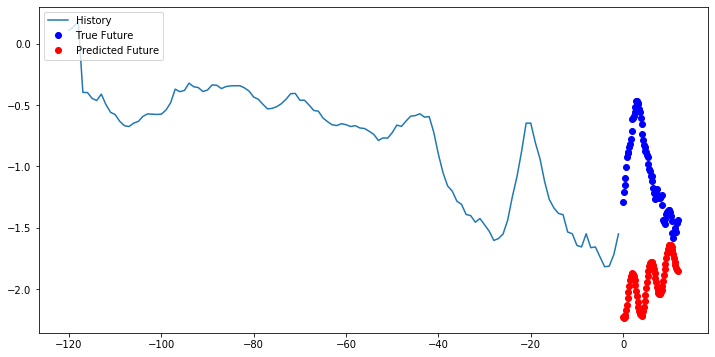

Mean absolute percentage error of sample 419757 for Multi-Step SSA Forecasting (Progressive Training) with NimbusML: 108.78359864491091%.


In [60]:
#With Gani's progressive SSA Training idea
#Experimenting
# Predicting
#     x_multi_progressive[:i].flatten() is equivalent to batch[i]
#i = random.randint(0, len(y_multi_progressive))
i = len(x_multi_progressive)-2
B_val_multi_prog_ssa = pd.Series(x_multi_progressive[:i+1].flatten(), name="T (degC)")
pipeline_multi_prog_ssa_pipeline = get_multi_prog_ssa_pipeline(90*(i+1), 24, 4*(i+1), 72)
pipeline_multi_prog_ssa_pipeline.fit(B_val_multi_prog_ssa)
# Predicted values
p_val_multi_prog_ssa = pipeline_multi_prog_ssa_pipeline.transform(pd.Series(x_multi_progressive[:i].flatten(), name="T (degC)")).drop("T (degC)", 1)
predicted_vals_multi = [0 for _ in range(72)]
count = 0
for (_, columnData) in p_val_multi_prog_ssa.iteritems():
    predicted_vals_multi[count] = columnData.values[119]
    count += 1
multi_step_plot(x_multi_progressive[i], y_multi_progressive[i], np.asarray(predicted_vals_multi))
# Performance
# mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
mape = np.mean(np.abs(abs(y_multi_progressive[i] - predicted_vals_multi) / abs(y_multi_progressive[i]))) * 100
print("Mean absolute percentage error of sample {} for Multi-Step SSA Forecasting (Progressive Training) with NimbusML: {}%.".format(i, mape))